## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [5]:
train, test = keras.datasets.cifar10.load_data()

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [22]:
"""Code Here
  建立你的神經網路
"""
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [23]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [27]:
"""Code Here
建立實驗的比較組合
"""
from keras.callbacks import ReduceLROnPlateau
reduce_lr_factor = [0.25, 0.75]
redice_lr_patient = [5, 10]
sgd = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
rms = keras.optimizers.RMSprop(lr=LEARNING_RATE)
optimizer_set = [sgd, adam, rms]

In [30]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, optim: %s, reduce_factor: %.2f, reduce_patient: %i" % (i, optim, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                min_lr=1e-12, 
                monitor='val_loss', 
                patience=reduce_patient, 
                verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, optim: <keras.optimizers.SGD object at 0x00000188BB817CF8>, reduce_factor: 0.25, reduce_patient: 5
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______

50000/50000 [==============================] - 4s 86us/step - loss: 0.2558 - accuracy: 0.9071 - val_loss: 0.2613 - val_accuracy: 0.9060
Epoch 11/25
50000/50000 [==============================] - 4s 84us/step - loss: 0.2530 - accuracy: 0.9077 - val_loss: 0.2600 - val_accuracy: 0.9064
Epoch 12/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.2506 - accuracy: 0.9085 - val_loss: 0.2587 - val_accuracy: 0.9066
Epoch 13/25
50000/50000 [==============================] - 4s 85us/step - loss: 0.2483 - accuracy: 0.9092 - val_loss: 0.2577 - val_accuracy: 0.9066
Epoch 14/25
50000/50000 [==============================] - 4s 85us/step - loss: 0.2464 - accuracy: 0.9096 - val_loss: 0.2566 - val_accuracy: 0.9072
Epoch 15/25
50000/50000 [==============================] - 4s 83us/step - loss: 0.2445 - accuracy: 0.9102 - val_loss: 0.2558 - val_accuracy: 0.9072
Epoch 16/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.2425 - accuracy: 0.9108 - val_loss: 0.2544

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 101us/step - loss: 0.3776 - accuracy: 0.8863 - val_loss: 0.3184 - val_accuracy: 0.9000
Epoch 2/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.3228 - accuracy: 0.8936 - val_loss: 0.3092 - val_accuracy: 0.9000
Epoch 3/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.3013 - accuracy: 0.8973 - val_loss: 0.2992 - val_accuracy: 0.9002
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.2889 - accuracy: 0.8994 - val_loss: 0.2891 - val_accuracy: 0.9011
Epoch 5/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.2803 - accuracy: 0.9011 - val_loss: 0.2809 - val_accuracy: 0.9021
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.2735 - accuracy: 0.9026 - val_loss: 0.2737 - val_accuracy: 0.9034
Epoch 7/25
50000/50000 [==============================] - 5s 99us/s

50000/50000 [==============================] - 4s 88us/step - loss: 0.1005 - accuracy: 0.9656 - val_loss: 0.2155 - val_accuracy: 0.9190
Epoch 20/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.0993 - accuracy: 0.9662 - val_loss: 0.2182 - val_accuracy: 0.9186
Epoch 21/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.0982 - accuracy: 0.9666 - val_loss: 0.2177 - val_accuracy: 0.9185
Epoch 22/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.0973 - accuracy: 0.9670 - val_loss: 0.2215 - val_accuracy: 0.9175

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 23/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.0951 - accuracy: 0.9679 - val_loss: 0.2180 - val_accuracy: 0.9189
Epoch 24/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.0947 - accuracy: 0.9684 - val_loss: 0.2186 - val_accuracy: 0.9187
Epoch 25/25
50000/50000 [=================

50000/50000 [==============================] - 4s 86us/step - loss: 0.2618 - accuracy: 0.9053 - val_loss: 0.2952 - val_accuracy: 0.9001
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.2494 - accuracy: 0.9086 - val_loss: 0.2765 - val_accuracy: 0.9019
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.2414 - accuracy: 0.9108 - val_loss: 0.2619 - val_accuracy: 0.9044
Epoch 5/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.2361 - accuracy: 0.9124 - val_loss: 0.2516 - val_accuracy: 0.9067
Epoch 6/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.2315 - accuracy: 0.9139 - val_loss: 0.2447 - val_accuracy: 0.9091
Epoch 7/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.2277 - accuracy: 0.9151 - val_loss: 0.2412 - val_accuracy: 0.9106
Epoch 8/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.2244 - accuracy: 0.9163 - val_loss: 0.2385 - val

Epoch 22/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.1968 - accuracy: 0.9259 - val_loss: 0.2310 - val_accuracy: 0.9134
Epoch 23/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.1955 - accuracy: 0.9266 - val_loss: 0.2313 - val_accuracy: 0.9130
Epoch 24/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.1943 - accuracy: 0.9269 - val_loss: 0.2303 - val_accuracy: 0.9129
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.1930 - accuracy: 0.9275 - val_loss: 0.2300 - val_accuracy: 0.9137
Numbers of exp: 8, optim: <keras.optimizers.RMSprop object at 0x00000188AC5FABE0>, reduce_factor: 0.25, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidd

Epoch 5/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.2298 - accuracy: 0.9141 - val_loss: 0.2491 - val_accuracy: 0.9075
Epoch 6/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.2234 - accuracy: 0.9164 - val_loss: 0.2440 - val_accuracy: 0.9090
Epoch 7/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.2174 - accuracy: 0.9185 - val_loss: 0.2390 - val_accuracy: 0.9110
Epoch 8/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.2125 - accuracy: 0.9202 - val_loss: 0.2361 - val_accuracy: 0.9117
Epoch 9/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.2085 - accuracy: 0.9215 - val_loss: 0.2364 - val_accuracy: 0.9105
Epoch 10/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.2041 - accuracy: 0.9231 - val_loss: 0.2345 - val_accuracy: 0.9124
Epoch 11/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.2004 - accuracy: 0.9243 - val_loss:

Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.1611 - accuracy: 0.9401 - val_loss: 0.2251 - val_accuracy: 0.9155
Numbers of exp: 11, optim: <keras.optimizers.RMSprop object at 0x00000188AC5FABE0>, reduce_factor: 0.75, reduce_patient: 10
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_82 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)          

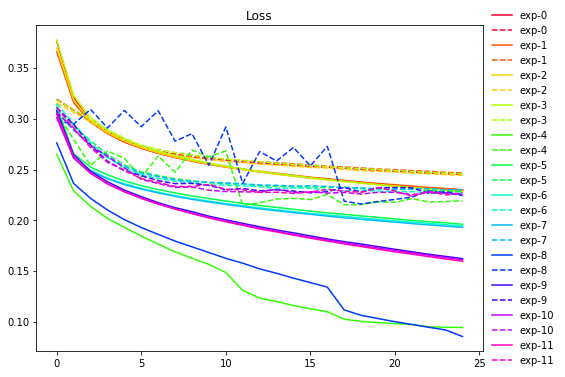

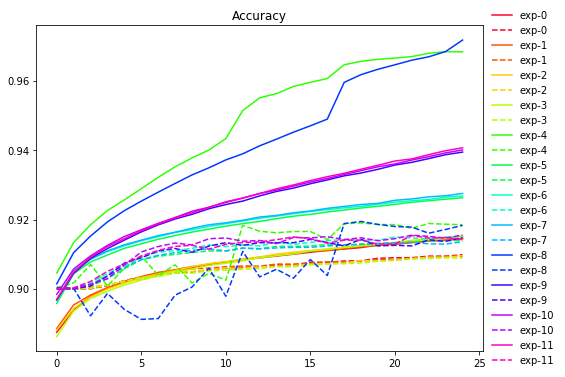

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

## 結論 : (1) 以RMSprop, reduce_factor: 0.75, reduce_patient: 5 & 10的兩組有較佳的驗證結果. (2) 相反的, RMSprop, reduce_factor: 0.25, reduce_patient: 5在第17回合達到提早結束的條件; Adam, reduce_factor: 0.25, reduce_patient: 5則是在第11回合. 因此, reduce_factor訂高一點有利於模型的訓練成果.